# SVM

Notebook to train a SVM model.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [2]:
import numpy as np
import pandas as pd

In [3]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_training.csv')

## Preprocessing

In [4]:
# still need to one hot team1_name and team2_name

raw_train_df = pd.get_dummies(raw_train_df, columns=['team1_name', 'team2_name', 'season_type'])
raw_test_df = pd.get_dummies(raw_test_df, columns=['team1_name', 'team2_name', 'season_type'])

# drop columns: venue, start_hour
raw_train_df = raw_train_df.drop(columns=['venue', 'start_hour'], axis=1)
raw_test_df = raw_test_df.drop(columns=['venue', 'start_hour'], axis=1)

In [5]:
train_cols = raw_train_df.columns
raw_test_df = raw_test_df[train_cols].copy()

In [6]:
# see if there are any columns that are not in both dataframes
train_cols = set(raw_train_df.columns)
test_cols = set(raw_test_df.columns)

# make sure that the columns are the same
print(test_cols == train_cols)

True


In [7]:
raw_train_df.head(3)

,attendance,is_federal_holiday,on_grass,temperature,wind_speed,team1_pre_win,team1_pre_loss,team1_pre_win_pct,team1_streak,team2_pre_win,...,team2_name_SDP,team2_name_SEA,team2_name_SFG,team2_name_STL,team2_name_TBR,team2_name_TEX,team2_name_TOR,team2_name_WSN,season_type_post,season_type_regular
0,35055,0,1,-2.786672,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
1,49043,0,1,0.705205,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
2,43633,0,1,-0.521670,1.490839,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1


In [8]:
X, y = raw_train_df.drop(columns=['attendance'], axis=1), raw_train_df['attendance']

## Model Building

### Model Evaluation Function

In [9]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [10]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV

### Simple SVM Model

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train)
y_pred_simple = regr.predict(X_valid)

_ = measure_model(y_valid, y_pred_simple, title='Simple SVM Regressor')

========== Simple SVM Regressor ==========
MSE: 105412224.42
RMSE: 10267.05
MAE: 8668.08
MAPE: 0.38


### Hyperparameter Tuning

In [12]:
def find_best_index(eval_results: dict[str, np.array]) -> int:
    # returns a n-scorers x n-parameter-set dimensional array
    means_of_splits = np.array(
        [values for name, values in eval_results.items() if name.startswith('mean_test')]
    )
    # this is a n-parameter-set dimensional vector
    mean_of_all_scores = np.mean(means_of_splits, axis=0) 
    # get index of maximum value which corresponds to the best parameter set
    return np.argmax(mean_of_all_scores) 

In [14]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
param_grid = {'C': [10, 100], 'gamma': [1, 10]}

grid = GridSearchCV(SVR(kernel='linear'),param_grid, refit=find_best_index, verbose=2, scoring=scoring, cv=5, n_jobs=-1)
grid.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': [10, 100], 'gamma': [1, 10]},
             refit=<function find_best_index at 0x000002A23F1856C0>,
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=2)

### Use the best hyperparameters to train the model

In [21]:
grid.best_estimator_

SVR(C=100, gamma=1, kernel='linear')

In [26]:
regr = SVR(kernel='linear', **grid.best_params_).fit(X, y)

In [27]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle

regr_filename = f'{datetime.today().strftime("%Y%m%d")}_svm_model_C100.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

In [28]:
def f_importances(coef, names, size=10):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), reverse=True))

    if size > len(names):
        size = len(names)
    plt.barh(range(size), imp[:size][::-1], align='center')
    plt.yticks(range(size), names[:size][::-1])
    plt.show()

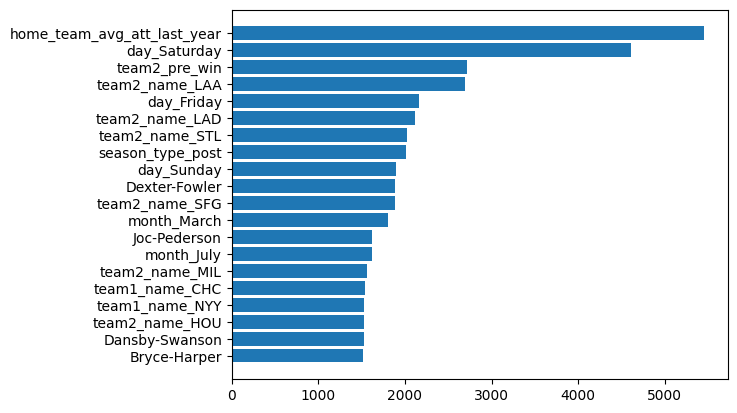

In [30]:
# matplotlib
import matplotlib.pyplot as plt

f_importances(regr.coef_[0], list(X.columns), size=20)

## Model Evaluation

In [31]:
X_test, y_test = raw_test_df.drop(columns=['attendance'], axis=1), raw_test_df['attendance']

In [34]:
# read model
import pickle
regr = pickle.load(open('20221127_svm_model_C100.pkl', 'rb'))
y_pred = regr.predict(X_test)

# performance
train_test_performance = measure_model(y, regr.predict(X), title='SVM Regressor Train')
test_performance = measure_model(y_test, y_pred, title='SVM Regressor Test')

========== SVM Regressor Train ==========
MSE: 28300357.20
RMSE: 5319.81
MAE: 3991.55
MAPE: 0.16
========== SVM Regressor Test ==========
MSE: 42378898.12
RMSE: 6509.91
MAE: 4998.06
MAPE: 0.23


Note:

+ The model does an ok job with SVM, but still can be improved through following ways (same as baggin):
    1. Player data may be too noisy, we can try to cut down player features with PCA or maybe just use salary ranks
    2. Venue capacities vary a lot, it'd be better if we can first group venues by capacity and then train models for each group
+ During hyper-parameter tuning session, 
    + fortunately, `linear` kernel is picked, so `coef_` can be plotted
    + unfortunately, we weren't able to run many parameters here, some features have to be reduced in order to do so
    + **Synthesis**: need to reduce some features
+ When comparing the bagging model with the baseline model, we see that baseline (MA-5) did slightly better, but it does way better than **average attendance of a stadium**, and better than `Bagging Regressor`
+ It seems like Decision Tree is fed on some players and deem them important ones
+ `home team avg att last year` is still the most important feature; it's worth noticing that `Dexter Fowler` is also listed as one of the top-10 most important featuers. 

```
==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
```

```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```

```
========== Bagging Regressor ==========
MSE: 44278142.04
RMSE: 6654.18
MAE: 5128.62
MAPE: 0.26
```


```
========== SVM (C=10)==========
MSE: 43639164.99
RMSE: 6605.99
MAE: 5045.63
MAPE: 0.24
```

```
========== Decision Tree ==========
MSE: 68199851.14
RMSE: 8258.32
MAE: 6695.69
MAPE: 0.37
```

```
========== SVM Regressor (C=100) ==========
MSE: 42378898.12
RMSE: 6509.91
MAE: 4998.06
MAPE: 0.23
```